In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from matplotlib.colors import ListedColormap 



from importlib import reload
import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

import utils.videowriter
reload(utils.videowriter)
from utils.videowriter import VideoWriter
import encasm
reload(encasm)
import encasm.eval
reload(encasm.eval)
from encasm.eval import load_tests

data_dir = "./encasm/example_networks/"
test_envs = load_tests(folder = data_dir, flat=True)

import encasm.env
reload(encasm.env)
from encasm.env import PetriDish

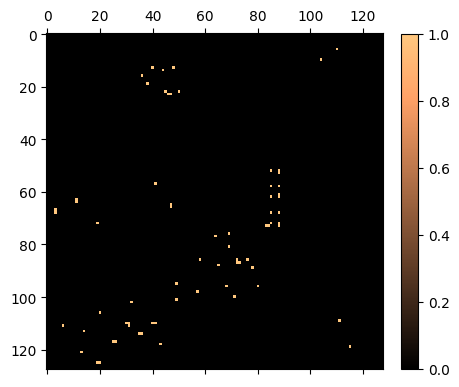

In [2]:
# displays test env large 6
test_envs["med_9-1"].display(chs=["food"], cols=1)

In [3]:
# applies a 2d convolution to the grid using scipy and the given kernel
def convolve(grid, kernel):
    return signal.convolve2d(grid, kernel, mode='same', boundary='fill', fillvalue=0)

def diffuse(r,l, cutoff=0.5):
    l = l>0 # convert to boolean in case it isn't

    kernel = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
    ksum = np.sum(kernel)

    # cutoff = np.random.random(r.shape)*0.25+0.3
    free_cells = (r < cutoff) * l # free cells are those that are not full 
    # sources are those that are full and have at least one free neighbor
    sources = (r >= cutoff) * l

    # How large of an area could a cell's resevoir flow to
    flow_area = convolve(free_cells, kernel) * l
    flow_area[l] += 1 # every cell includes itself

    # Nonzero just avoids divide by zero, this is just 5/flow_area * r, which is the adjusted nutrients 
    # to "bounce back" diffusion off of full cells and voids
    to_diff = np.divide(ksum, flow_area, out=np.zeros_like(r), where=flow_area!=0) * r

    kernel[1,1] = 1
    kernel *= (1./ksum)
    sinks = convolve(to_diff, kernel) * free_cells # sinks serve as sources to other sinks too


    # creates an array where free_cells have the value of sinks and sources have the value of to_diff * 0.2
    diffused = np.zeros_like(r)
    diffused[free_cells] = sinks[free_cells]
    diffused[sources] = to_diff[sources] * (1./ksum)
    return diffused

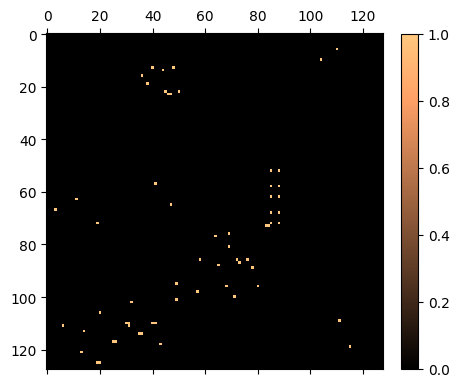

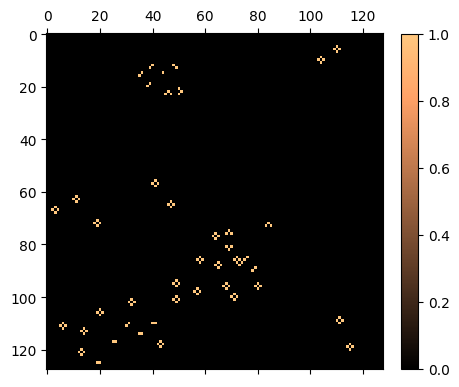

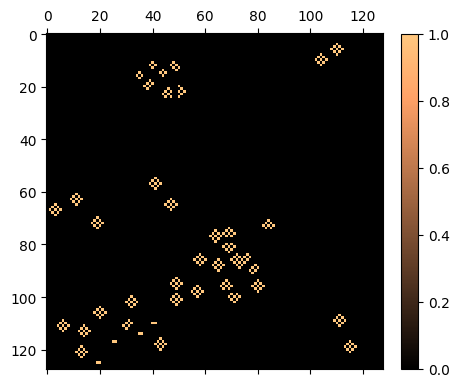

In [4]:
def collapse_food_cells(food_grid):
    # collapses clusters of adjacent food cells into one food cell
    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.float32)

    # convolves the food grid with the kernel
    convolved = convolve(food_grid, kernel)
    convolved = convolve(convolved, kernel)
    convolved = convolve(convolved, kernel)

    # max kernel
    kernel = np.array([[0,-0.25,0],[-0.25,1,-0.25],[0,-0.25,0]], dtype=np.float32)
    convolved = convolve(convolved, kernel)
    

    # collapses clusters of adjacent food cells into one food cell
    food_grid[convolved >= 5] = 1
    food_grid[convolved < 5] = 0

    return food_grid

# Creates from 9 1
tenv = PetriDish.from_env("tenv", test_envs["med_9-1"])
# tests collapse_food_cells
tenv.display(chs=["food"], cols=1)
tenv.food = collapse_food_cells(tenv.food)
tenv.display(chs=["food"], cols=1)
tenv.food = collapse_food_cells(tenv.food)
tenv.display(chs=["food"], cols=1)


In [5]:
a = test_envs["med_9-1"].fd()
a.sum()


62

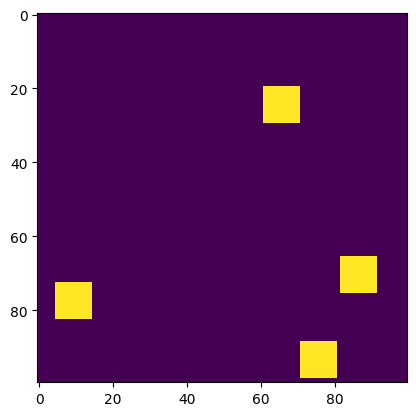

In [6]:
def get_random_chunk_mask(grid_shape, chunk_shape):
    # returns a boolean mask of the given shape with a random chunk of the given shape set to True
    mask = np.zeros(grid_shape, dtype=bool)
    x = np.random.randint(0, grid_shape[0]-chunk_shape[0])
    y = np.random.randint(0, grid_shape[1]-chunk_shape[1])
    mask[x:x+chunk_shape[0],y:y+chunk_shape[1]] = True
    return mask

def get_random_chunk_masks(grid_shape, chunk_shape, n):
    # returns a list of n random chunk masks
    return [get_random_chunk_mask(grid_shape, chunk_shape) for _ in range(n)]

# applies and displays n random chunk masks
ex = np.zeros((100,100))
for mask in get_random_chunk_masks(ex.shape, (10,10), 4):
    ex[mask] = 1
plt.imshow(ex)

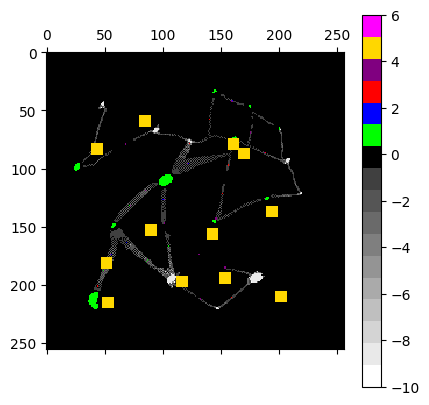

In [102]:
# Defines a color bar where negative values are shades of red (larger is darker)
# and positive values are discrete defined by map_colors
map_colors = ["#000000", "#00FF00", "#0000FF", "#FF0000", "#800080", "#FFD700", "#FF00FF"]
# list of grey hex colors from dark to light
grey_colors = ["#"+hex(i)[2:]*3 for i in np.linspace(255, 64, 10, dtype=int)]
# red_colors = ["#%02x0000" % (i) for i in range(255, 0, -16)]

# adds red_colors to beginning of map colors
map_colors = grey_colors + map_colors

# creates a ListedColormap from map_colors
cmap = ListedColormap(map_colors)
to_disp = tenv.map+ tenv.resv*-1
for mask in masks_l:
    to_disp[mask] = 5
to_disp[0,0] = -10
to_disp[0,1] = 6
plt.matshow(to_disp, cmap=cmap)
plt.colorbar()

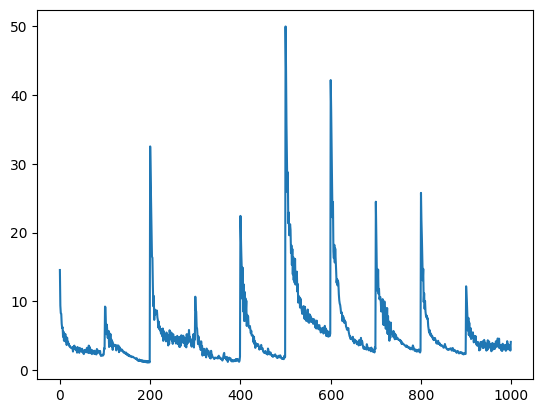

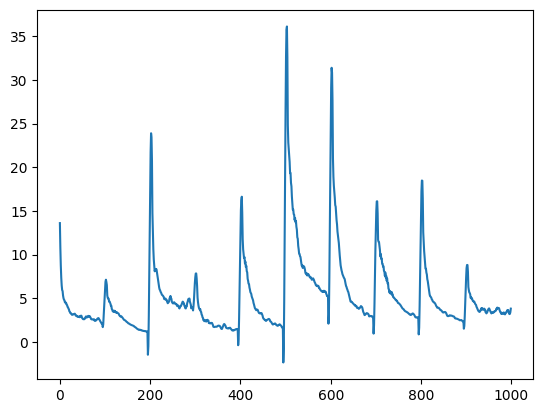

In [108]:
max_food = 10 # max food value
cutoff = 1 # the cutoff for when a cell is considered full
food_rate = 1 # nutrient generation rate per food cell
sink_rate = 1 # % resevoir expelled at sinks
eat_rate = 0.001 # nutrients eaten per cell per tick
n_masks = 10 # number of random chunk masks to apply
percent_food_sinks = 0.1 # % of food cells counted as sinks 
tenv = PetriDish.from_env("tenv", test_envs["med_9-1"])
chunk_shape = np.array([tenv.width//5,tenv.width//5]) # shape of random chunk masks
water_rate = 0.1 # % of resevoir that is lost to water
# tenv = PetriDish.from_config_file("tenv", "./encasm/example_networks/med/med.config")

# # adds 3x3 clump on the middle left of the food channel
# curr_food = tenv.fd()
# curr_food[tenv.height//2-3:tenv.height//2+3, 0:5] = 1
# tenv.set_channel("food", curr_food)

# # adds a horizontal stripe of life through the middle of the life channel
# curr_life = tenv.life
# curr_life[tenv.height//2-1:tenv.height//2+1, :] = 1
# tenv.set_channel("life", curr_life)

# # adds a sink to the middle far right 
# curr_sink = tenv.sk()
# curr_sink[tenv.height//2, tenv.width-15] = 1
# tenv.set_channel("sink", curr_sink)

tenv.resv += tenv.life  # sets the resevoir to the max_food value for all cells with life


diffs = []
life = np.copy(tenv.life)
food = np.copy(tenv.food)
tenv.sink = np.zeros_like(tenv.sink)
# Records a video of diffusion in tenv
with VideoWriter("./encasm/results/diffusion.mp4", fps=33) as vid:
    for i in range(1000):
        if i % 100 == 0:
            tenv.life = np.copy(life)
            # Sets random chunks of life to 0, saves life and restores
            masks_l = get_random_chunk_masks(life.shape, chunk_shape//5, 12)
        
            for mask in masks_l:
                tenv.life[mask] = 0

            # Sets sinks to all of the food in masks
            masks = get_random_chunk_masks(tenv.food.shape, chunk_shape, n_masks)
            tenv.sink = np.zeros_like(tenv.sink)
            for mask in masks:
                tenv.food = np.copy(food)
                tenv.sink[mask] = tenv.food[mask]
                tenv.food[mask] = 0
        
        presv = tenv.resv
        tenv.resv = diffuse(tenv.resv, tenv.life, cutoff=cutoff)

        tenv.resv += tenv.food*(tenv.sink<1)*food_rate
    
        # Removes nutrients from cells on poison
        tenv.resv -= tenv.poison*max_food

        # Removes nutrients from cells on water
        tenv.resv -= tenv.water*water_rate

        tenv.resv -= tenv.life*eat_rate # eats nutrients from the resevoir

        tenv.resv = np.clip(tenv.resv, 0, max_food)

        sink_matrix = np.log(1+(tenv.resv * tenv.sink * sink_rate))
        diffs.append((sink_matrix).sum())
        tenv.resv -= sink_matrix # removes nutrients from sinks
        tenv.resv = np.clip(tenv.resv, 0, max_food)
        # tenv.resv -= tenv.ps
        if i % 2 == 0:

            tenv.resv[0,0] = max_food
            tenv.resv[0,1] = 0
            # avg of presv and resv
            avg = (presv + tenv.resv)/2.
            to_disp = tenv.map+ tenv.resv*-1
            to_disp[tenv.food>0] = 1
            for mask in masks_l:
                to_disp[mask*life] = 5
            for mask in masks:
                to_disp[mask*tenv.sink] = 6
            to_disp[0,0] = -10
            to_disp[0,1] = 5
            vid.add_concat_grids([to_disp], scale=4, cmaps=[cmap], cols = 1)
diffs = np.array(diffs)
plt.plot(diffs)
plt.show()

# smooths diffs
diffs = signal.savgol_filter(diffs, 11, 3)
plt.plot(diffs)
plt.show()

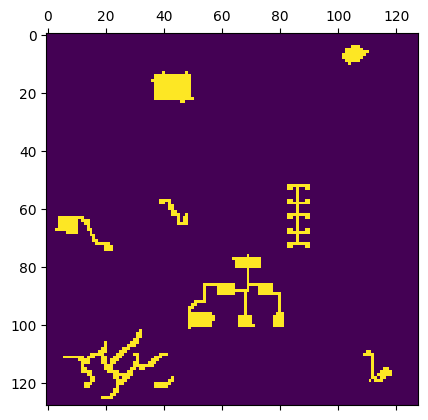

In [98]:
plt.matshow(tenv.life)

/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/85627392.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x))


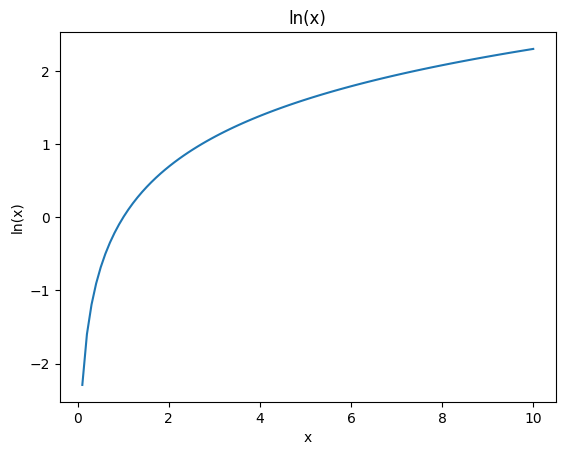

In [825]:
# plots ln and titles axes from -10 to 10
x = np.linspace(0,10,100)
plt.plot(x, np.log(x))

plt.title("ln(x)")
plt.xlabel("x")
plt.ylabel("ln(x)")
plt.show()

In [826]:
np.log(x)

/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/1277889159.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(x)


array([       -inf, -2.29253476, -1.59938758, -1.19392247, -0.9062404 ,
       -0.68309684, -0.50077529, -0.34662461, -0.21309322, -0.09531018,
        0.01005034,  0.10536052,  0.19237189,  0.2724146 ,  0.34652257,
        0.41551544,  0.48005397,  0.54067859,  0.597837  ,  0.65190422,
        0.70319752,  0.75198768,  0.7985077 ,  0.84295946,  0.88551907,
        0.92634107,  0.96556178,  1.00330211,  1.03966975,  1.07476107,
        1.10866262,  1.14145245,  1.17320115,  1.2039728 ,  1.23382577,
        1.2628133 ,  1.29098418,  1.31838316,  1.3450514 ,  1.37102689,
        1.3963447 ,  1.42103731,  1.44513486,  1.46866536,  1.49165488,
        1.51412773,  1.53610664,  1.55761284,  1.57866625,  1.59928554,
        1.61948825,  1.63929088,  1.65870896,  1.67775716,  1.69644929,
        1.71479843,  1.73281693,  1.75051651,  1.76790825,  1.78500269,
        1.80180981,  1.81833911,  1.83459963,  1.85059997,  1.86634833,
        1.88185251,  1.89711998,  1.91215786,  1.92697295,  1.94

In [741]:
import datetime

# Runs diffusion for all of the given environments and variables produces a video grid of envs for each set of variables 
def run_diffusion(envs, max_food, cutoff, food_rate, sink_rate, eat_rate, name):
    # Creates the folder ./encasm/results/curr_date/time if it doesnt exist
    folder = "./encasm/results/"+str(datetime.datetime.now()).replace(" ", "_").replace(":", "-")+"/"

In [742]:
# "./encasm/results/"+str(datetime.datetime.now()).replace(" ", "_").replace(":", "-")+"/"
# todays date

'./encasm/results/2022-11-30_11-47-07.658603/'

In [ ]:
import datetime

# Runs a simulation of diffusion for all the passed in environment keys (got from test_envs)
# Displays a grid of named and labeled graphs of the nutrients captured by sinks and stores videos of the simulation in results/[curr_date/time]
def run_diffusion(keys, init_food = 0.25, max_food=10, cutoff=0.5, food_rate=0.25, sink_rate=1, eat_rate=0.01, n_steps=200):
    for key in keys:
        # creates a new environment and sets the initial food
        nutrient_lvls = []
        tenv = PetriDish.from_env(key, test_envs[key])
        tenv.resv += tenv.fd()*max_food
        tenv.resv += tenv.life*init_food
        # Creates the folder ./encasm/results/curr_date/time if it doesnt exist
        folder = "./encasm/results/"+str(datetime.datetime.now()).replace(" ", "_").replace(":", "-")+"/"
        
        # Runs diffusion and stores the video in folder
        with VideoWriter(folder+key+".mp4", fps=33) as vid:
            for i in range(n_steps):
                # if i<0:
                tenv.resv += tenv.fd()*food_rate
                tenv.resv -= tenv.life*eat_rate
                tenv.resv = diffuse(tenv.resv, tenv.life, cutoff=cutoff)

                nutrient_lvls.append((tenv.resv * tenv.sk()*sink_rate).sum())
                tenv.resv -= tenv.sk()*sink_rate
    

In [169]:
von_n = np.array([[0,1,0],[1,0,1],[0,1,0]], dtype=np.float32)
von_nc = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.float32)
von_avg = np.array([[0,0.2,0],[0.2,0.2,0.2],[0,0.2,0]], dtype=np.float32)

In [405]:
grid_size = 32
# Indexes of 2d chunks spacing

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

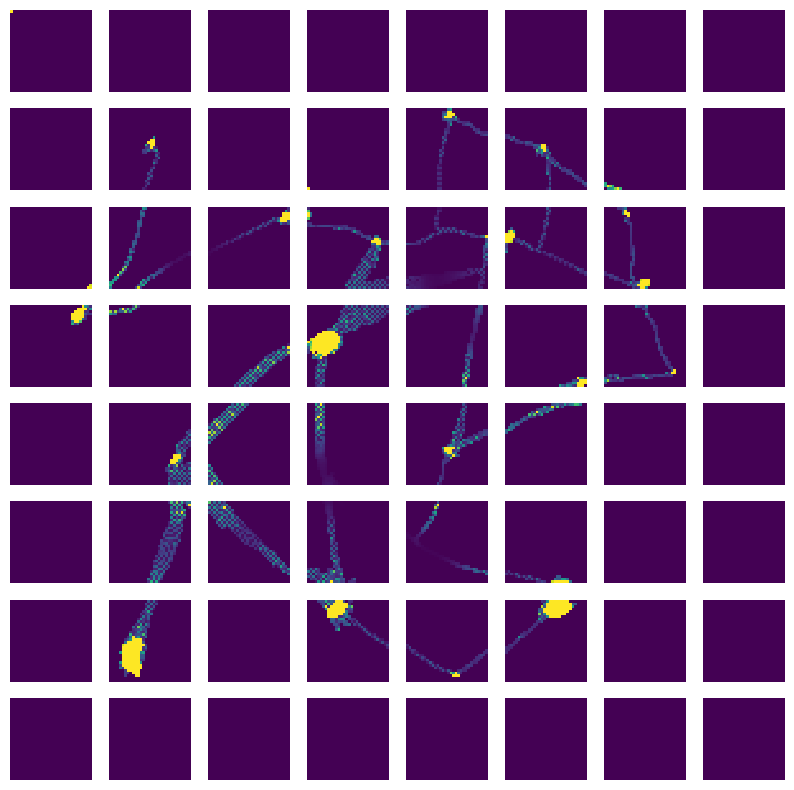

In [399]:
spacing = 32
# fetches spacing by spacing tiles from the resevoir
tiles = np.array([tenv.resv[i:i+spacing, j:j+spacing] for i in range(0, tenv.width, spacing) for j in range(0, tenv.width, spacing)])

# displays all tiles in a large grid figure
fig, axs = plt.subplots(math.ceil(tenv.width/spacing), math.ceil(tenv.width/spacing), figsize=(10,10))
for i in range(math.ceil(tenv.width/spacing)):
    for j in range(math.ceil(tenv.width/spacing)):
        axs[i,j].matshow(tiles[i*int(math.ceil(tenv.width/spacing))+j], cmap="viridis")
        axs[i,j].axis("off")
plt.show()
# for i in range(len(tiles)):

#     plt.subplot(4,4,i+1)
#     plt.imshow(tiles[i], cmap="viridis")
#     plt.colorbar()
#     plt.title(f"Tile {i}")

In [389]:
# plt.matshow(tenv.resv)

w = tenv.width
cutw = spacing*(w//spacing)
src = tenv.resv[:cutw,:cutw]
src = src.reshape((spacing, spacing, (w//spacing)*(w//spacing)))

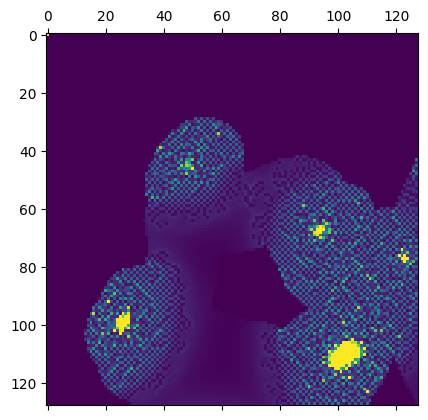

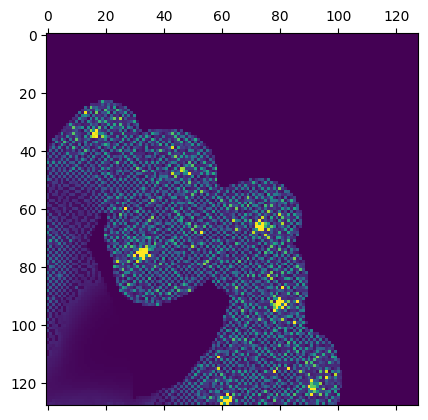

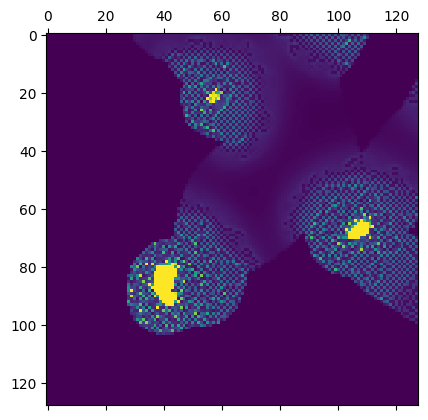

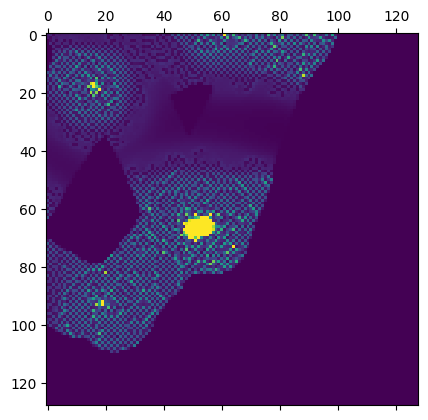

In [ ]:

# displays r and l with colorbars shrunk to 0.45
# fig, axs = plt.subplots(1,2, figsize=(10,10))
# fig.colorbar(axs[0].matshow(r), ax=axs[0], shrink=0.35)
# fig.colorbar(axs[1].matshow(l), ax=axs[1], shrink=0.35)

# diffuses r and l 100 times and makes a video  
with VideoWriter(filename="./encasm/results/diffusion.mp4", fps=2) as vw:
    for i in range(100):
        # r = diffuse(r,l, cutoff = 0.3)
        # # adds nutrients to the resevoir of the middle
        r[w//2,w//2] += 0.1

        neigh_sum = convolve(r, von_nc)
        neigh_size = convolve(l, von_nc)

        r = np.where(neigh_size>0, r, neigh_sum/neigh_size)


        r[0,0] = 1
        vw.add_concat_grids([r], cols=1)



In [194]:
# 2d array example
a = np.array([[1,2,3],[4,5,0],[7,8,9]])
np.where(a!=0, 1/a, a)

/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/310576515.py:3: RuntimeWarning: divide by zero encountered in divide
  np.where(a!=0, 1/a, a)


array([[1.        , 0.5       , 0.33333333],
       [0.25      , 0.2       , 0.        ],
       [0.14285714, 0.125     , 0.11111111]])

/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/231250835.py:27: RuntimeWarning: invalid value encountered in divide
  fig.colorbar(axs[2].matshow(np.where(neigh_size>0, neigh_sum/neigh_size, 0)), ax=axs[2], shrink=0.35)
/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/231250835.py:30: RuntimeWarning: invalid value encountered in divide
  print(np.where(neigh_size>0, neigh_sum/neigh_size, 0).sum())


3.0
3.15


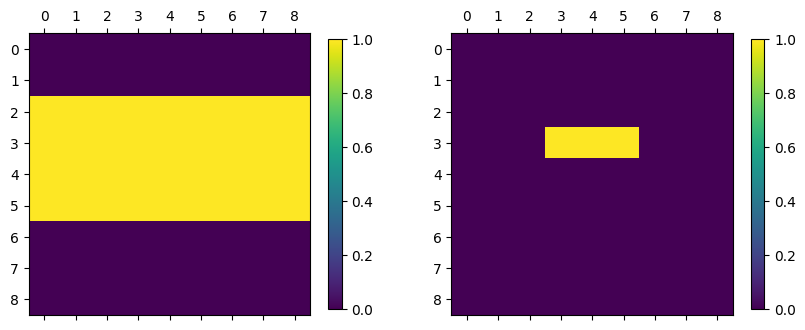

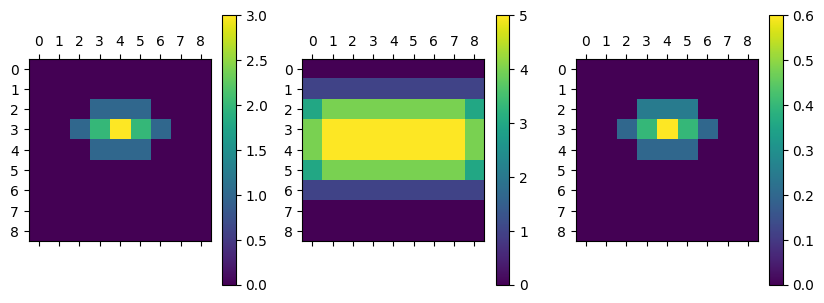

In [211]:
w = 9
# r and l are both wxw arrays
r = np.zeros((w,w), dtype=np.float32)
l = np.zeros((w,w), dtype=np.float32)

# r contains a horizontal stripe 1 wide and 3 long of nutrients in the center
r[w//2-1:w//2, w//2-1:w//2+2] = 1
# r[w//2:w//2+1,:] = 1
l[w//2-2:w//2+2,:] = 1


# l contains a horizontal stripe of life 3 wide and w long in the center

# displays r,l, and neigh arrays and their ratio accounting for 0s in the denominator 
fig, axs = plt.subplots(1,2, figsize=(10,10))
fig.colorbar(axs[0].matshow(l), ax=axs[0], shrink=0.35)
fig.colorbar(axs[1].matshow(r), ax=axs[1], shrink=0.35)


neigh_sum = convolve(r, von_nc)
neigh_size = convolve(l, von_nc)


fig, axs = plt.subplots(1,3, figsize=(10,10))
fig.colorbar(axs[0].matshow(neigh_sum), ax=axs[0], shrink=0.35)
fig.colorbar(axs[1].matshow(neigh_size), ax=axs[1], shrink=0.35)
fig.colorbar(axs[2].matshow(np.where(neigh_size>0, neigh_sum/neigh_size, 0)), ax=axs[2], shrink=0.35)

print(r.sum())
print(np.where(neigh_size>0, neigh_sum/neigh_size, 0).sum())
# shows the functionality of np.where to use a mask to set items in a
# np.where(neigh_size>0, r, neigh_sum/neigh_size)
# neigh_sum, neigh_size, np.where(neigh_size>0, neigh_sum/neigh_size, 0)

In [274]:
tenv.life = np.ones_like(tenv.life)

/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/3478897244.py:7: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(ax.matshow((convolve(r, kernel)*tenv.life)>0), cmap="hot")


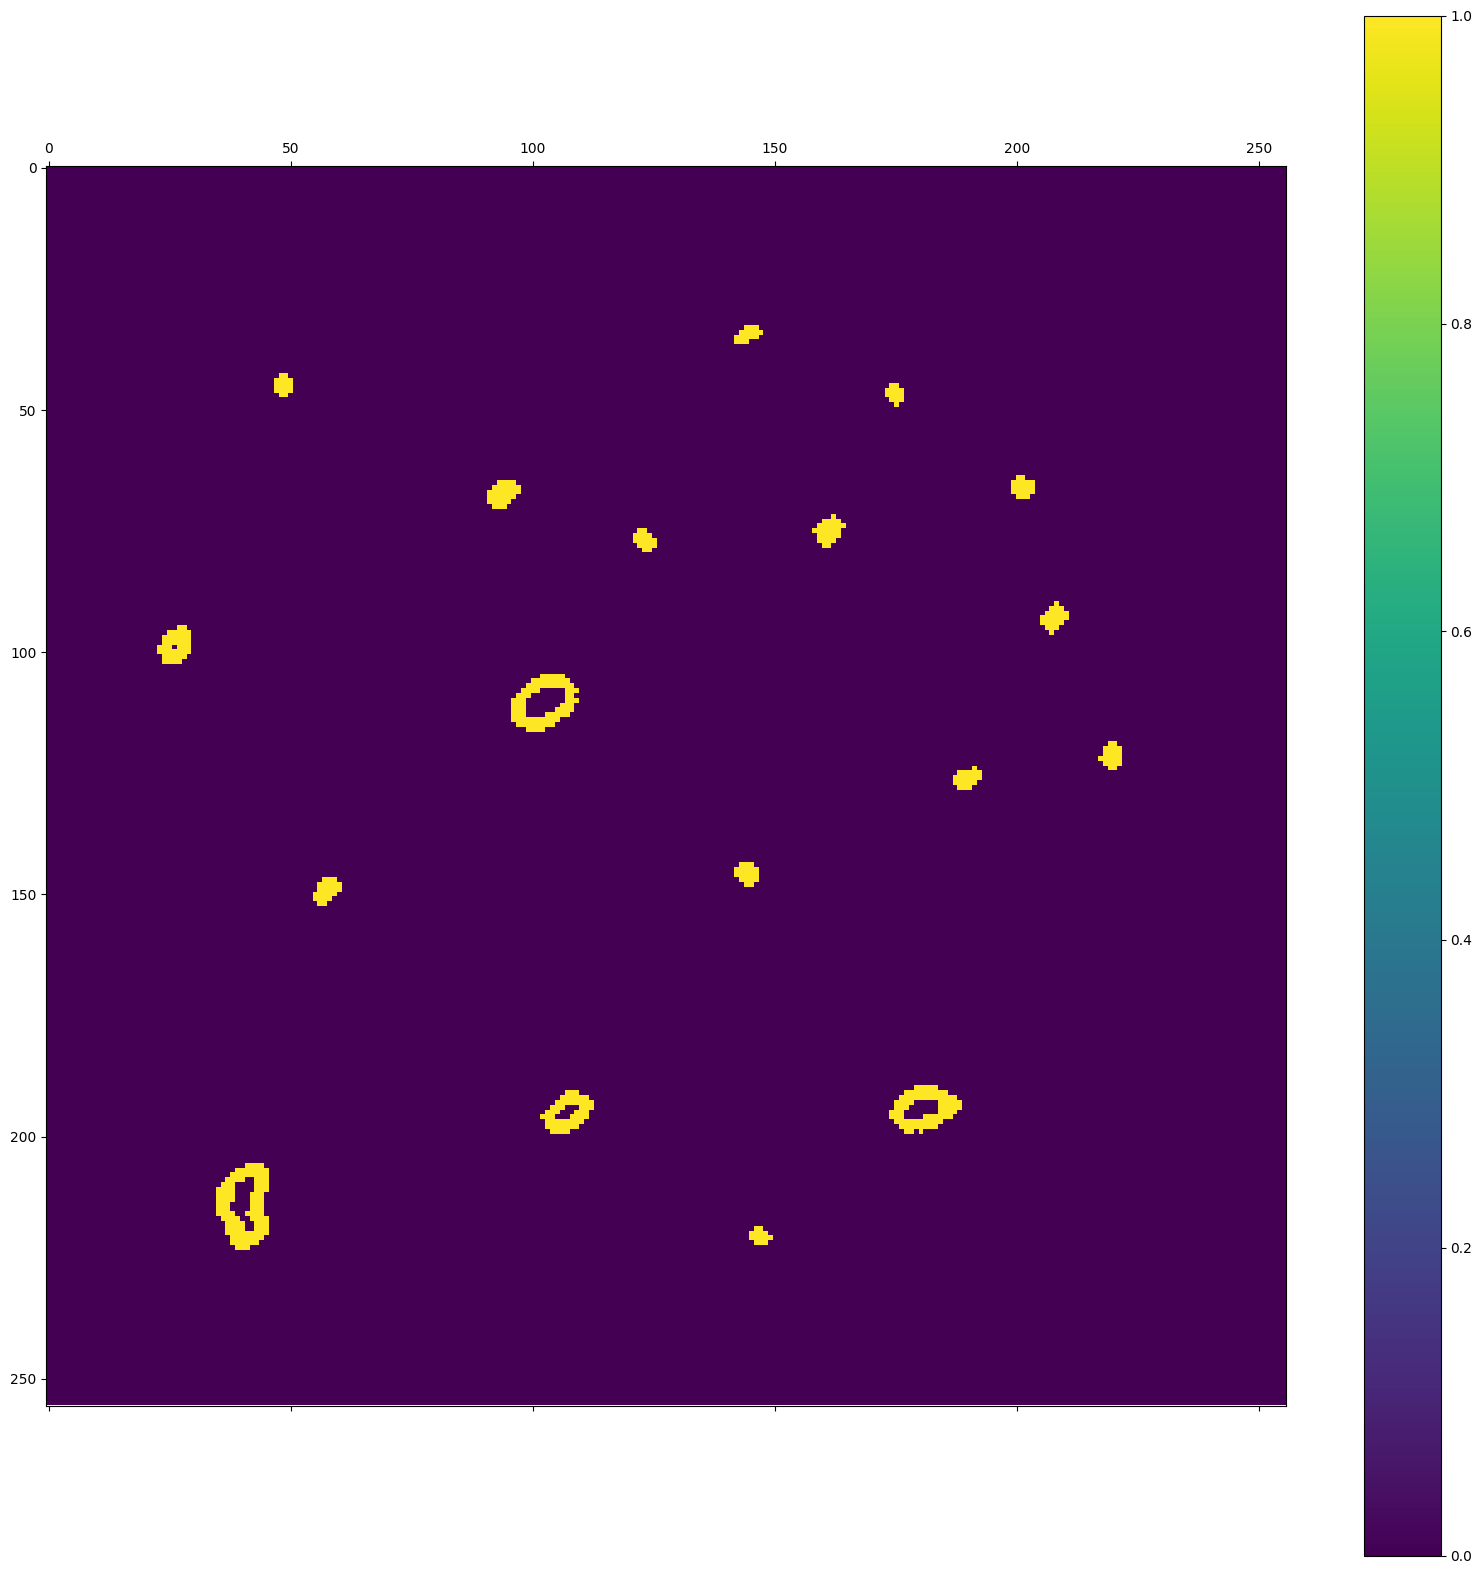

In [132]:
# copies env resv and convolved it with a kernel
r = tenv.resv.copy()
kernel = np.array([[0,-0.25,0],[-0.25,1,-0.25],[0,-0.25,0]], dtype=np.float32)
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
# adds colorbar 
fig.colorbar(ax.matshow((convolve(r, kernel)*tenv.life)>0), cmap="hot")


/var/folders/hw/yffqy09n2dx87f_f1pvgn6840000gn/T/ipykernel_1672/3711006157.py:3: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  fig.colorbar(ax.matshow((convolve(r, kernel)*tenv.life)<0), cmap="hot")


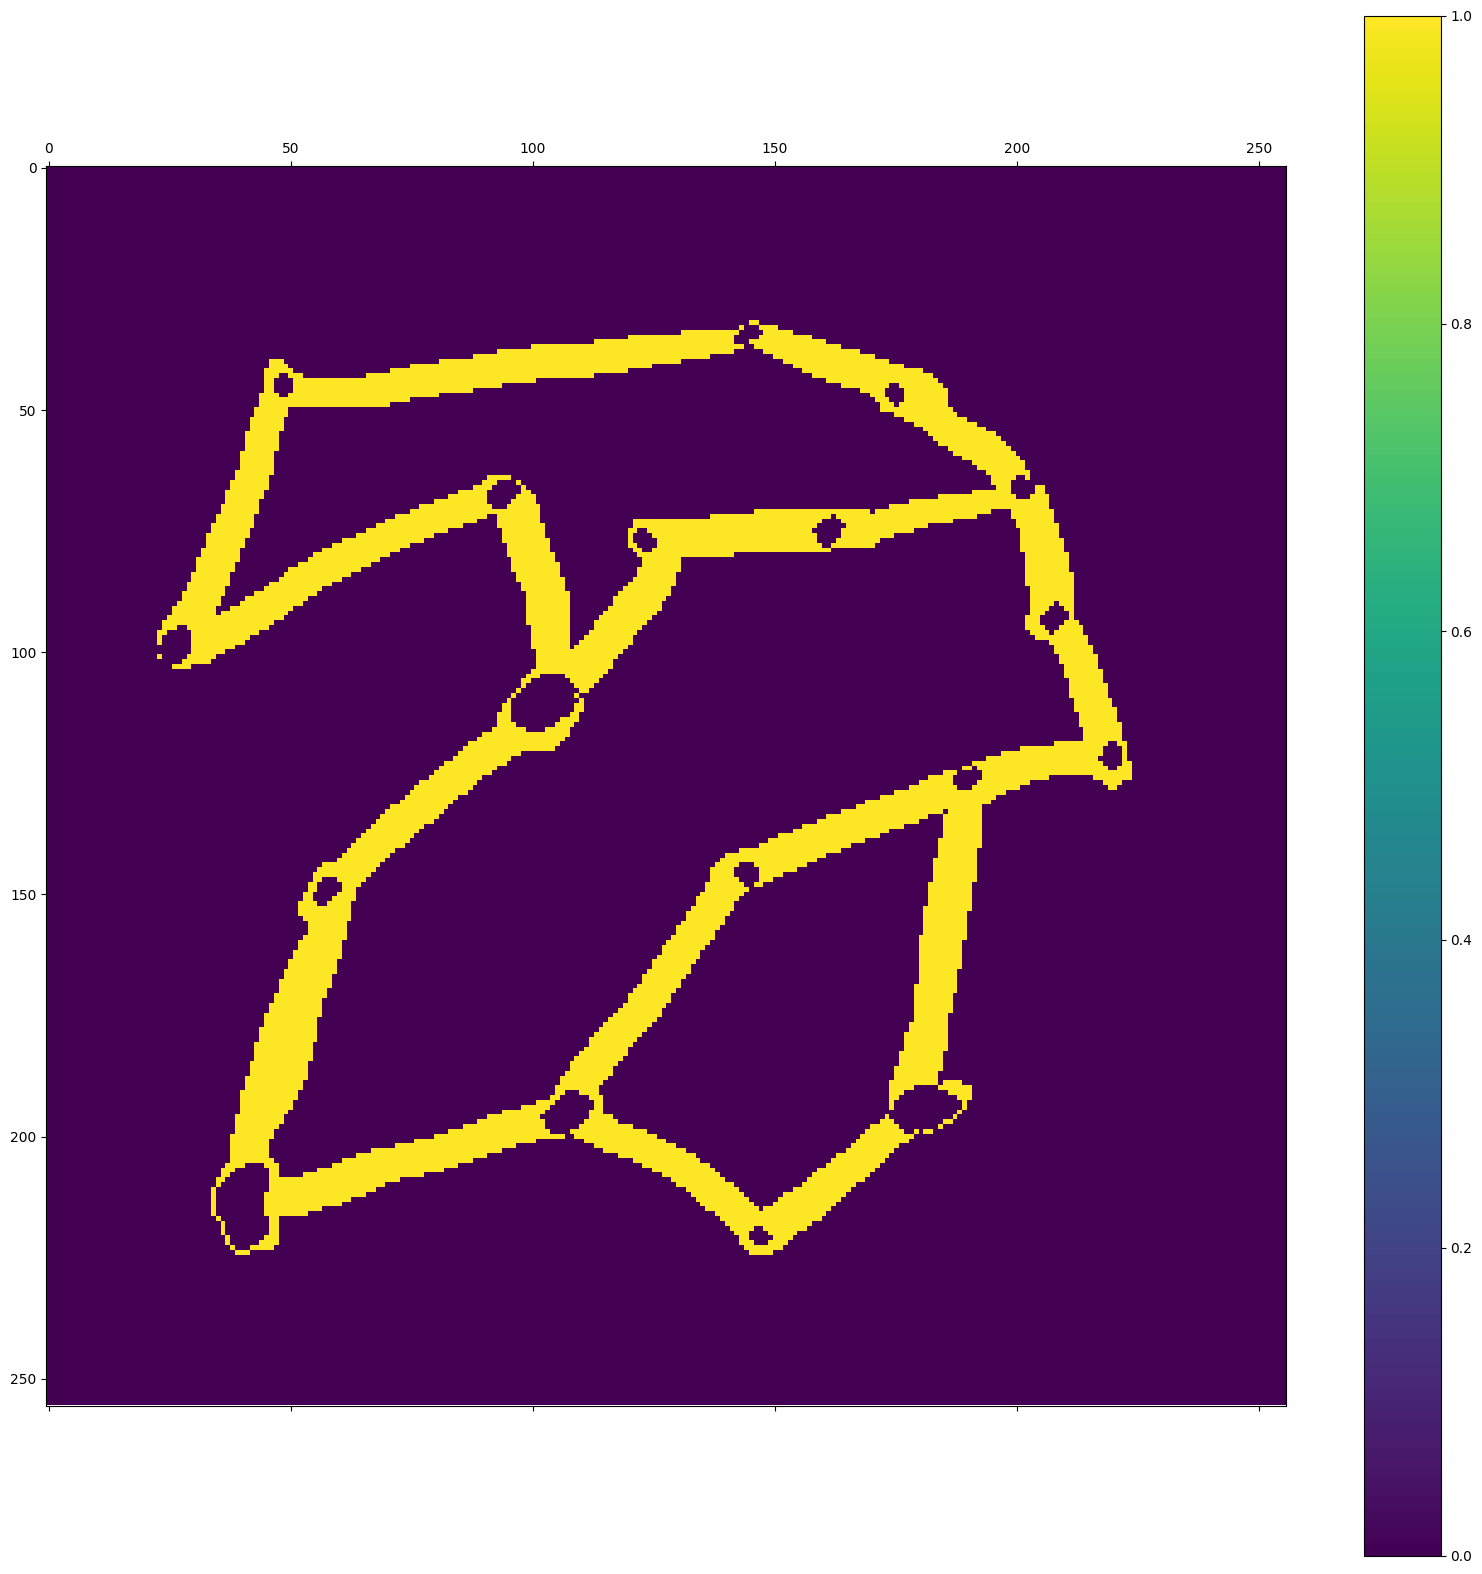

In [133]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
fig.colorbar(ax.matshow((convolve(r, kernel)*tenv.life)<0), cmap="hot")

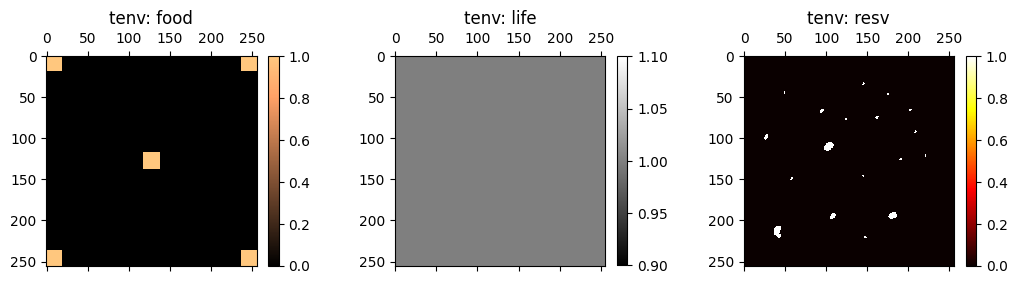

In [54]:
tenv.food = np.zeros_like(tenv.life)
tenv.life = np.ones_like(tenv.life)
# places blocks of food the size of sz in the corners and middle of a the food grid
sz=20
tenv.food[:sz,:sz] = 1
tenv.food[-sz:,-sz:] = 1
tenv.food[-sz:,:sz] = 1
tenv.food[:sz,-sz:] = 1
tenv.food[tenv.food.shape[0]//2-sz//2:tenv.food.shape[0]//2+sz//2,tenv.food.shape[1]//2-sz//2:tenv.food.shape[1]//2+sz//2] = 1


tenv.display()